In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox, Dropdown, Output
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
from IPython.display import display

import datetime

from scipy import linalg
from scipy import optimize
import sympy as sm
from IPython.display import display

# local module for linear algebra
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')
pd.set_option("display.precision", 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
#!pip install arch #Need to be installed

We examine the time-varying co-movements and portfolio diversification between Danish and German stock markets employing the symmetric conditional correlation multivariate GARCH models and following the minimum variance portfolio approach. We use daily return data for C20 and DAX30 indices for the period 2000 to 2021. This study finds a useful combination of Danish and German stock markets for construction of a portfolio in order to minimize the risk.

# Dynamic Conditional Correlation

In [ ]:
def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

In [ ]:
def garch_t_to_u(rets, res):
    mu = res.params['mu']
    nu = res.params['nu']
    est_r = rets - mu
    h = res.conditional_volatility
    std_res = est_r / h
    # we could also just use:
    # std_res = res.std_resid
    # but it's useful to see what is going on
    udata = t.cdf(std_res, nu)
    return udata

In [ ]:
def loglike_norm_dcc_copula(theta, udata):
    N, T = np.shape(udata)
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata).T, ndmin=2)
    
    
    Rt, veclRt =  dcceq(theta,trdata)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[:,:,i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[i,:] , (np.linalg.inv(Rt[:,:,i]) - np.eye(N))) ,trdata[i,:].T)
    llf = np.sum(llf)

    return -llf

In [ ]:
def dcceq(theta,trdata):
    T, N = np.shape(trdata)

    a, b = theta
    
    if min(a,b)<0 or max(a,b)>1 or a+b > .999999:
        a = .9999 - b
        
    Qt = np.zeros((N, N ,T))

    Qt[:,:,0] = np.cov(trdata.T)

    Rt =  np.zeros((N, N ,T))
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    
    Rt[:,:,0] = np.corrcoef(trdata.T)
    
    for j in range(1,T):
        Qt[:,:,j] = Qt[:,:,0] * (1-a-b)
        Qt[:,:,j] = Qt[:,:,j] + a * np.matmul(trdata[[j-1]].T, trdata[[j-1]])
        Qt[:,:,j] = Qt[:,:,j] + b * Qt[:,:,j-1]
        Rt[:,:,j] = np.divide(Qt[:,:,j] , np.matmul(np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2)).T , np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2))))
    
    for j in range(0,T):
        veclRt[j, :] = vecl(Rt[:,:,j].T)
    return Rt, veclRt

In [93]:
model_parameters = {}
udata_list = []

def run_garch_on_return(rets, udata_list, model_parameters):
    for x in rets:
        am = arch_model(rets[x], dist = 't')
        short_name = x.split()[0]
        model_parameters[short_name] = am.fit(disp='off')
        udata = garch_t_to_u(rets[x], model_parameters[short_name])
        udata_list.append(udata)
    return udata_list, model_parameters

## data

In [94]:
df = pd.read_excel('data/D.xlsx')
df.drop(columns='Unnamed: 0', inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date',inplace = True) 

In [95]:
udata_list, model_parameters = run_garch_on_return(df.loc[:,'DDAX30':'DC20'].dropna(), udata_list, model_parameters)

## Setup our DDC Model, and then run it on our data, df

In [96]:
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.5), (0, 0.9997))

In [97]:
%time opt_out = minimize(loglike_norm_dcc_copula, [0.01, 0.95], args = (udata_list,), bounds=bnds, constraints=cons)

CPU times: user 56.3 s, sys: 389 ms, total: 56.7 s
Wall time: 16.3 s


In [98]:
print(opt_out.success)
print(opt_out.x)

True
[0.03815038 0.94536462]


In [99]:
llf  = loglike_norm_dcc_copula(opt_out.x, udata_list)
llf

-1213.1373941853103

In [100]:
trdata = np.array(norm.ppf(udata_list).T, ndmin=2)
Rt, veclRt = dcceq(opt_out.x, trdata)

In [101]:
corr_name_list = ['DAX30 - C20']
stock_names = ['DDAX30','DC20']

## Plotting

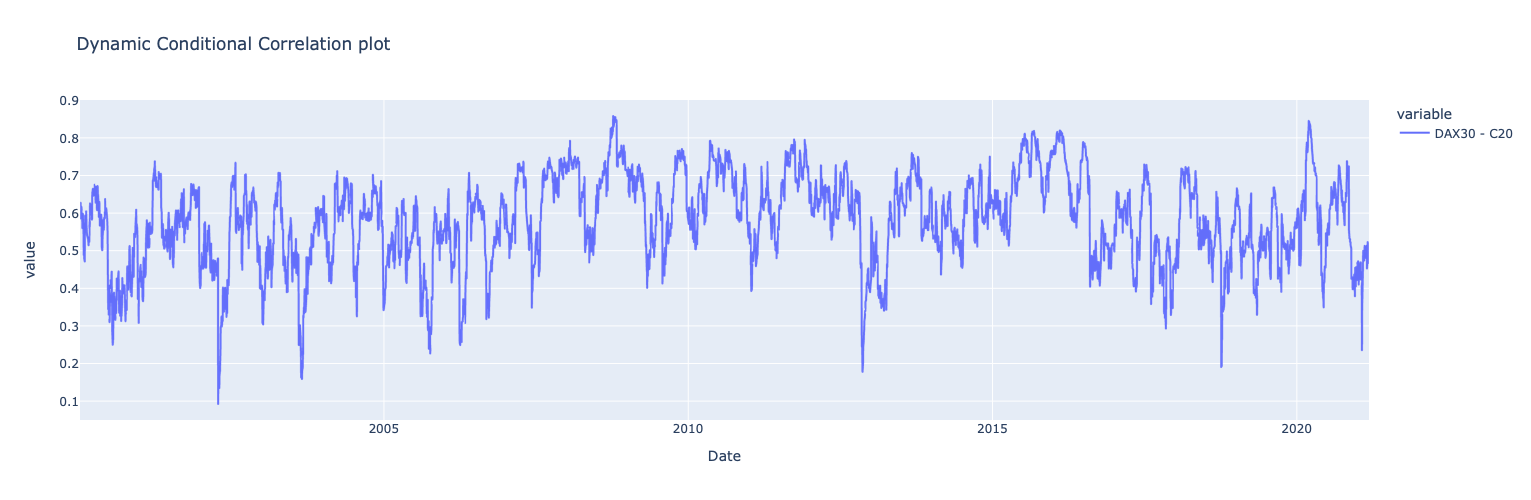

In [102]:
dcc_corr = pd.DataFrame(veclRt, index = df.loc[:,'DDAX30':'DC20'].dropna().index, columns= corr_name_list)
dcc_plot = px.line(dcc_corr, title = 'Dynamic Conditional Correlation plot', width=1000, height=500)
dcc_plot.show()

In [103]:
garch_vol_df = pd.concat([pd.DataFrame(model_parameters[x].conditional_volatility/100)*1600 for x in model_parameters], axis=1)
garch_vol_df.columns = stock_names

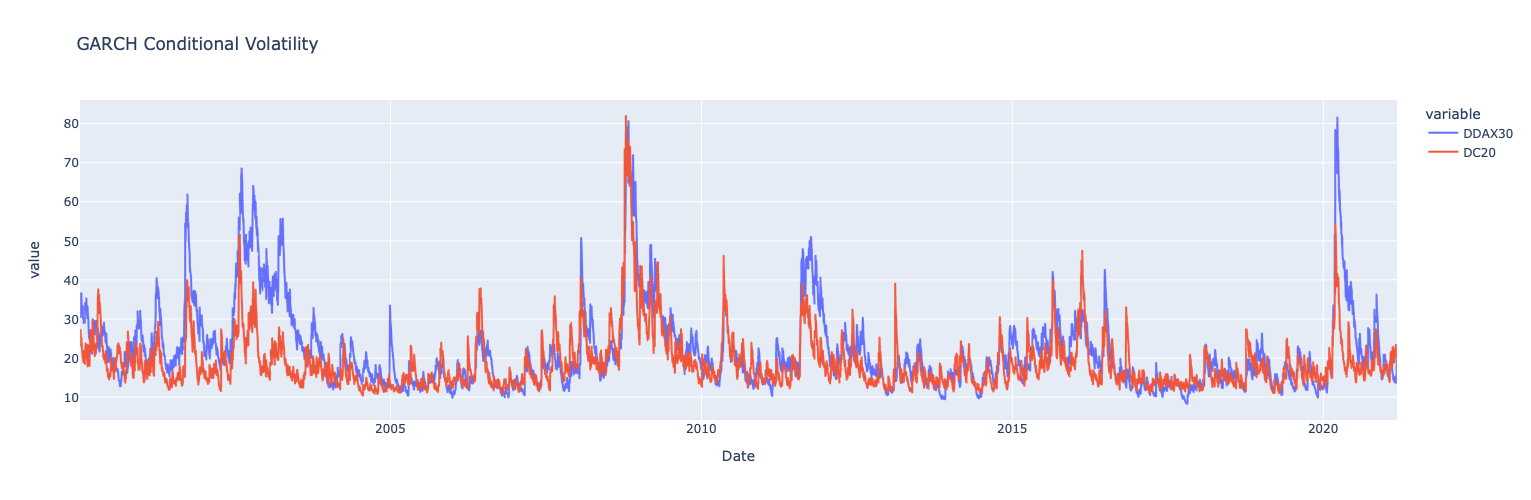

In [104]:
px.line(garch_vol_df, title='GARCH Conditional Volatility', width=1000, height=500).show()

In [105]:
#Cumulative returns of DAX30 and C20

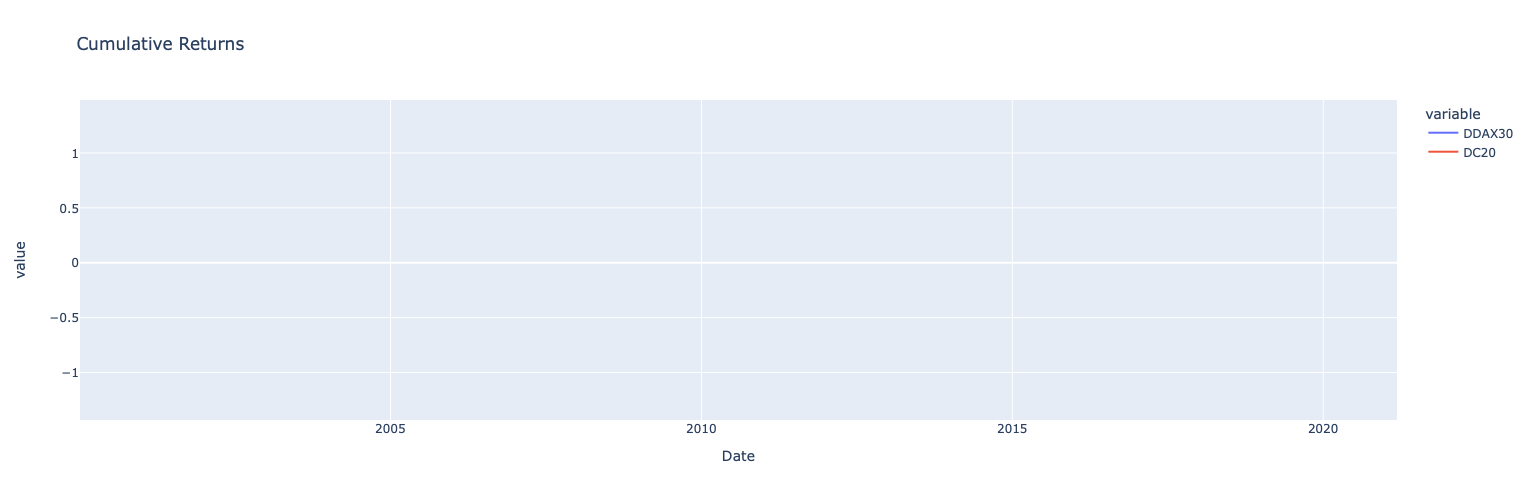

In [106]:
px.line(np.log((1+df.loc[:,'DDAX30':'DC20'].dropna()/100).cumprod()), title='Cumulative Returns', width=1000, height=500).show()

In [107]:
df.loc[:,'DDAX30':'DC20'].dropna().corr() #unconditional correlation

,DDAX30,DC20
DDAX30,1.00000,0.61016
DC20,0.61016,1.00000


Assuming that the investor is risk-averse and wants to minimize the variance of the portfolio, we can derive the first-order condition for the minimum-variance portfolio weights. The time-varying weights to DAX30 index in the minimum-variance portfolio:
$$\begin{aligned}
\bar{\sigma}_t^2=\vartheta_t^2\sigma_{1,t}^2+(1-\vartheta_t)^2\sigma_{2,t}^2+2\vartheta_t(1-\vartheta_t)\sigma_{12,t}
\end{aligned}
$$

$$\begin{aligned}
\frac{\partial\bar{\sigma}_t^2}{\partial\vartheta_t}=2\vartheta_t\sigma_{1,t}^2-2(1-\vartheta_t)\sigma_{2,t}^2+2\sigma_{12,t}-4\vartheta_t\sigma_{12,t}=0 \\
\end{aligned}
$$
$$
\begin{aligned}
\vartheta_t=\frac{\sigma_{2,t}^2-\sigma_{12,t}}{\sigma_{1,t}^2+\sigma_{2,t}^2-2\sigma_{12,t}}
\end{aligned}$$


In [108]:
# calculating weights manualy, just check

In [109]:
sigma_1 =garch_vol_df['DDAX30']
sigma_2 =garch_vol_df['DC20']
sigma_1_sq =(garch_vol_df['DDAX30']**2)
sigma_2_sq = (garch_vol_df['DC20']**2)
sigma_12 = (sigma_1 *sigma_2*dcc_corr['DAX30 - C20'])

In [110]:
weights = (sigma_2_sq - sigma_12)/(sigma_1_sq + sigma_2_sq - 2 * sigma_12)

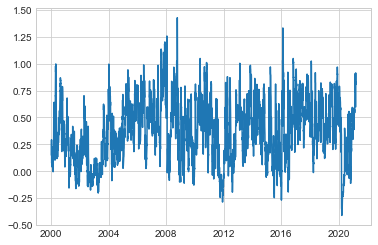

In [111]:
plt.plot(weights);

In [121]:
sigma_1 = sm.symbols('sigma_1')
sigma_2 = sm.symbols('sigma_2')
sigma_12 = sm.symbols('sigma_12')
vartheta = sm.symbols('vartheta')

$$\begin{aligned}
\bar{\sigma}_t^2=\vartheta_t^2\sigma_{1,t}^2+(1-\vartheta_t)^2\sigma_{2,t}^2+2\vartheta_t(1-\vartheta_t)\sigma_{12,t}
\end{aligned}
$$

In [122]:
f = vartheta**2 * sigma_1**2 + (1-vartheta)**2 * sigma_2**2 + 2*vartheta*(1-vartheta)*sigma_12
f

sigma_1**2*vartheta**2 + 2*sigma_12*vartheta*(1 - vartheta) + sigma_2**2*(1 - vartheta)**2

In [123]:
fnk = sm.lambdify((sigma_1,sigma_2,sigma_12,vartheta),f)

In [124]:
fnk

<function _lambdifygenerated(sigma_1, sigma_2, sigma_12, vartheta)>